<html>
<body>
    <table style="border: none" align="center">
        <tr style="border: none">
            <th style="border: none"><img src="https://github.com/pmservice/customer-satisfaction-prediction/blob/master/app/static/images/ml_icon_gray.png?raw=true" alt="Watson Machine Learning icon" height="45" width="45"></th>
            <th style="border: none"><font face="verdana" size="6" color="black"><b>Watson Machine Learning</b></font></th>
        </tr>
    </table>
</body>

This notebook contains steps and code to define a custom operation using tf.py_func operation in tensorflow. The custom operation is then used in a LeNet network for handwritten character recognition which is trained on the MNIST dataset. The trained model is persisted, deployed and scored using the Watson Machine Learning Service and the Watson Machine Learning Client.

Some familiarity with Python is helpful. This notebook uses Python-3.5, numpy-1.14 and tensorflow-1.5.

## Learning goals

The learning goals of this notebook are:

-  Define a custom operation and corresponding gradient using `tf.py_func`
-  Create a LeNet model using the defined custom operation
-  Train the model on the MNIST dataset
-  Create a library containing the custom tensor operation
-  Persist the library and the model in Watson Machine Learning repository.
-  Deploy the model using Watson Machine Learning Service
-  Perform some classifications using the deployed model


## Contents

This notebook contains the following parts:

1.  [Setup the environment](#setup)
1.  [Create operation for tf.py_func and download library](#func)
2.	[Load data and initialize parameters](#load)
3.	[Create and train Lenet model](#model)
4.  [Save model locally](#save)
5.  [Persist library and runtime resource](#lib_persistence)
6.	[Persist Lenet model in Cloud](#persistence)
7.  [Deploy and perform prediction on the Lenet model](#Scoring)
8.  [Summary](#summary)


<a id="setup"></a>
## 1. Set up the environment

Before you use the sample code in this notebook, you must perform the following setup tasks:

-  Create a [Watson Machine Learning (WML) Service](https://console.bluemix.net/catalog/services/machine-learning) instance (a lite  plan is offered and information about how to create the instance is [here](https://dataplatform.ibm.com/docs/content/analyze-data/wml-setup.html))
- Configure your local python environment:
  + python 3.5
  + tensorflow 1.5
  + watson-machine-learning-client, version: 1.0.293 or above


In [1]:
!rm -rf $PIP_BUILD/watson-machine-learning-client

In [2]:
!pip install watson-machine-learning-client --upgrade

Requirement already up-to-date: watson-machine-learning-client in /Users/jinsalex/anaconda3/lib/python3.6/site-packages
Requirement already up-to-date: tqdm in /Users/jinsalex/anaconda3/lib/python3.6/site-packages (from watson-machine-learning-client)
Requirement already up-to-date: urllib3 in /Users/jinsalex/anaconda3/lib/python3.6/site-packages (from watson-machine-learning-client)
Requirement already up-to-date: lomond in /Users/jinsalex/anaconda3/lib/python3.6/site-packages (from watson-machine-learning-client)
Requirement already up-to-date: pandas in /Users/jinsalex/anaconda3/lib/python3.6/site-packages (from watson-machine-learning-client)
Requirement already up-to-date: certifi in /Users/jinsalex/anaconda3/lib/python3.6/site-packages (from watson-machine-learning-client)
Requirement already up-to-date: requests in /Users/jinsalex/anaconda3/lib/python3.6/site-packages (from watson-machine-learning-client)
Requirement already up-to-date: tabulate in /Users/jinsalex/anaconda3/lib/

<a id="func"></a>
## 2. Create operation for tf.py_func and download library


### 2.1 Create custom operation for tf.py_func

While creating a custom operation for tf.py_func, it is also necessary to create the corresponding gradient function. Tensorflow maps any function passed to tf.py_func under the `PyFunc` operation type. Tensorflow models perform gradient calculation during training. Hence, a user defined `tf.py_func` operation requires a corresponding gradient function defined and mapped to the `PyFunc` operation type. In this example, `reshape_grad` is the gradient function for the `tf.py_func` operation.

In [3]:
import tensorflow as tf
import numpy as np
from tensorflow.python.framework import ops 

def reshape_func(x):
    return x.reshape((-1, 28, 28, 1)) 

def reshape_grad(op, grad):
    x = op.inputs[0]

    return grad

def create_py_func_with_grads(op, inp, tout, stateful=True, name=None, grad=None):
    grad_name = 'PyFuncGrad' + str(np.random.randint(0, 1e+8))

    tf.RegisterGradient(grad_name)(grad)
    g = tf.get_default_graph()

    with g.gradient_override_map({"PyFunc": grad_name}):
        return tf.py_func(op, inp, tout, stateful=stateful, name=name)


/Users/jinsalex/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### 2.2 Downloading library

In order to store and deploy models that use operations defined through `tf.py_func`, a python distributable library needs to be created. The library should contain an `initialize_py_func()` function which defines the `tf.py_func` operation. The operation defined within this function should have the same name as the operation created during model definition and training. Also, `initialize_py_func()` function must be referenceable using the top-level module name. For example, if top-level 
module in the python distribution package is `my_top_module`, then `initialize_py_func()` must be referenceable as 
`my_top_module.initialize_py_func()`.

Currently, only source distributed libraries archived in `.zip` format are supported. Libraries distributions of type `wheels` and `eggs` are not supported

Any 3rd party libraries that are required for the custom transformer must be defined as the dependency for the corresponding library that contains implementation of the transformer. 

Here, we download the library `custom_reshape_pyfunc.zip` which defines the reshape operation

In [4]:
!wget https://github.com/pmservice/wml-sample-models/raw/master/tensorflow/custom-op-hand-written-digit-recognition/libraries/custom_reshape_pyfunc-0.1.zip --output-document=custom_reshape_pyfunc.zip

--2019-06-11 16:48:43--  https://github.com/pmservice/wml-sample-models/raw/master/tensorflow/custom-op-hand-written-digit-recognition/libraries/custom_reshape_pyfunc-0.1.zip
Resolving github.com... 13.234.210.38
Connecting to github.com|13.234.210.38|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/pmservice/wml-sample-models/master/tensorflow/custom-op-hand-written-digit-recognition/libraries/custom_reshape_pyfunc-0.1.zip [following]
--2019-06-11 16:48:43--  https://raw.githubusercontent.com/pmservice/wml-sample-models/master/tensorflow/custom-op-hand-written-digit-recognition/libraries/custom_reshape_pyfunc-0.1.zip
Resolving raw.githubusercontent.com... 151.101.36.133
Connecting to raw.githubusercontent.com|151.101.36.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3138 (3.1K) [application/zip]
Saving to: ‘custom_reshape_pyfunc.zip’

custom_reshape_pyfu 100%[===================>]   3.06K  -

<a id="load"></a>
## 3. Load data and initialize parameters

Downloading the MNIST dataset from Yann LeCunn's homepage using the built-in tensorflow library

In [5]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


Setting Training and network parameters

In [6]:
# Training Parameters
learning_rate = 0.001
training_iters = 10000
batch_size = 128
display_step = 10

# Network Parameters
n_input = 784 
n_classes = 10 

<a id="model"></a>
## 4. Create and train Lenet model

### 4.1 Model creation

Defining placeholders and the default layer configurations for the network

In [7]:
# tf Graph input
x = tf.placeholder(tf.float32, [None, n_input], name="x_input")
y = tf.placeholder(tf.float32, [None, n_classes])

# Store layers weight & bias
weights = {
    # 5x5 conv, 1 input, 32 outputs
    'wc1': tf.Variable(tf.random_normal([5, 5, 1, 32])),
    # 5x5 conv, 32 inputs, 64 outputs
    'wc2': tf.Variable(tf.random_normal([5, 5, 32, 64])),
    # fully connected, 7*7*64 inputs, 1024 outputs
    'wd1': tf.Variable(tf.random_normal([7*7*64, 1024])),
    # 1024 inputs, 10 outputs (class prediction)
    'out': tf.Variable(tf.random_normal([1024, n_classes]))
}

biases = {
    'bc1': tf.Variable(tf.random_normal([32])),
    'bc2': tf.Variable(tf.random_normal([64])),
    'bd1': tf.Variable(tf.random_normal([1024])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

The `create_py_func_with_grads` function defines a `tf.py_func` operation along with the corresponding gradient and returns the resulting tensor.

In [8]:
x_trans1 = create_py_func_with_grads(reshape_func, [x], tf.float32, False, name='ReshapeFunc', grad=reshape_grad)

# Convolution Layer -1
x_conv2d_l1 = tf.nn.conv2d(x_trans1, weights['wc1'], strides=[1, 1, 1, 1], padding='SAME')
x_w_bias_l1 = tf.nn.bias_add(x_conv2d_l1, biases['bc1'])
x_relu_l1 = tf.nn.relu(x_w_bias_l1)
conv1_out = tf.nn.max_pool(x_relu_l1,
                           ksize=[1, 2, 2, 1],
                           strides=[1, 2, 2, 1],
                           padding='SAME')


# Convolution Layer -2
x_conv2d_l2 = tf.nn.conv2d(conv1_out, weights['wc2'], strides=[1, 1, 1, 1], padding='SAME')
x_w_bias_l2 = tf.nn.bias_add(x_conv2d_l2, biases['bc2'])
x_relu_l2 = tf.nn.relu(x_w_bias_l2)
conv2_out = tf.nn.max_pool(x_relu_l2,
                           ksize=[1, 2, 2, 1],
                           strides=[1, 2, 2, 1],
                           padding='SAME')

# Fully connected layer
# Reshape conv2 output to fit fully connected layer input
fc1 = tf.reshape(conv2_out, [-1, weights['wd1'].get_shape().as_list()[0]])
fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
fc1 = tf.nn.relu(fc1)

# Output, class prediction
conv_out = tf.add(tf.matmul(fc1, weights['out']), biases['out'], name="output_tensor")

predictor = tf.argmax(conv_out, 1, name="predictor")

# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=conv_out, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# To Evaluate model
correct_pred = tf.equal(tf.argmax(conv_out, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



Training the model

In [9]:
# Initializing the variables
init = tf.global_variables_initializer()
# Launch the graph
sess = tf.Session()
sess.run(init)
step = 1
# Keep training until reach max iterations
while step * batch_size < training_iters:
    batch_x, batch_y = mnist.train.next_batch(batch_size)
    # Run optimization op (backprop)
    sess.run(optimizer, feed_dict={x: batch_x, y: batch_y})
    print("Completed batch iteration: " + str(step*batch_size) )
    if step % display_step == 0:
        # Calculate batch loss and accuracy
        loss, acc = sess.run([cost, accuracy], feed_dict={x: batch_x,
                                                          y: batch_y})
    
        print("Iter " + str(step*batch_size) + ", Minibatch Loss= " + \
              "{:.6f}".format(loss) + ", Training Accuracy= " + \
              "{:.5f}".format(acc))
    step += 1
print("Model training finished!")

Completed batch iteration: 128
Completed batch iteration: 256
Completed batch iteration: 384
Completed batch iteration: 512
Completed batch iteration: 640
Completed batch iteration: 768
Completed batch iteration: 896
Completed batch iteration: 1024
Completed batch iteration: 1152
Completed batch iteration: 1280
Iter 1280, Minibatch Loss= 27310.554688, Training Accuracy= 0.23438
Completed batch iteration: 1408
Completed batch iteration: 1536
Completed batch iteration: 1664
Completed batch iteration: 1792
Completed batch iteration: 1920
Completed batch iteration: 2048
Completed batch iteration: 2176
Completed batch iteration: 2304
Completed batch iteration: 2432
Completed batch iteration: 2560
Iter 2560, Minibatch Loss= 10731.765625, Training Accuracy= 0.49219
Completed batch iteration: 2688
Completed batch iteration: 2816
Completed batch iteration: 2944
Completed batch iteration: 3072
Completed batch iteration: 3200
Completed batch iteration: 3328
Completed batch iteration: 3456
Complet

<a id="save"></a>

## 5. Save model locally

### 5.1 Save model locally using SavedModelBuilder

Remove previously created directory

In [10]:
import os, shutil
save_path = './tf_model_mnist_test'
# delete dir if directory exists
if os.path.exists(save_path):
    shutil.rmtree(save_path)

Create SignatureDef metadata for the model

In [11]:
classification_inputs = tf.saved_model.utils.build_tensor_info(x)
classification_outputs_classes = tf.saved_model.utils.build_tensor_info(predictor)

classification_signature = (
      tf.saved_model.signature_def_utils.build_signature_def(
          inputs={
              tf.saved_model.signature_constants.CLASSIFY_INPUTS:
                  classification_inputs
          },
          outputs={
              tf.saved_model.signature_constants.CLASSIFY_OUTPUT_CLASSES:
                  classification_outputs_classes
          },
          method_name=tf.saved_model.signature_constants.CLASSIFY_METHOD_NAME))

print("classification_signature content:")
print(classification_signature)

classification_signature content:
inputs {
  key: "inputs"
  value {
    name: "x_input:0"
    dtype: DT_FLOAT
    tensor_shape {
      dim {
        size: -1
      }
      dim {
        size: 784
      }
    }
  }
}
outputs {
  key: "classes"
  value {
    name: "predictor:0"
    dtype: DT_INT64
    tensor_shape {
      dim {
        size: -1
      }
    }
  }
}
method_name: "tensorflow/serving/classify"



Save the LeNet model locally using Tensorflow's SavedModelBuilder API

In [12]:
# Build the signature_def_map.

builder = tf.saved_model.builder.SavedModelBuilder(save_path)
legacy_init_op = tf.group(tf.tables_initializer(), name='legacy_init_op')
builder.add_meta_graph_and_variables(
      sess, [tf.saved_model.tag_constants.SERVING],
      signature_def_map={
          'predict_images': classification_signature,
      },
      legacy_init_op=legacy_init_op)

builder.save()

INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: b'./tf_model_mnist_test/saved_model.pb'


b'./tf_model_mnist_test/saved_model.pb'

<a id="lib_persistence"></a>
## 6. Persist library and model in WML Repository


In this section, using `watson_machine_learning_client`, you will ...
- save the library `custom_reshape_pyfunc.zip` in WML Repository by creating a Library resource
- create a Runtime resource and bind the Library resource to it. This Runtime resource will be used to configure the online deployment runtime environment for a model 


#### Saving the library as a library artifact in the WML repository

Authenticate to the Watson Machine Learning (WML) service on IBM Cloud.

**Tip**: Authentication information (your credentials) can be found in the [Service credentials](https://console.bluemix.net/docs/services/service_credentials.html#service_credentials) tab of the service instance that you created on IBM Cloud. 
If there are no credentials listed for your instance in **Service credentials**, click **New credential (+)** and enter the information required to generate new authentication information. 

**Action**: Enter your WML service instance credentials here.

In [13]:
wml_credentials = {
    "apikey"    : "value",
    "instance_id" : "instance_id",
    "url"    : "url"
}



In [14]:
from watson_machine_learning_client import WatsonMachineLearningAPIClient

/Users/jinsalex/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [15]:
client = WatsonMachineLearningAPIClient(wml_credentials)

While creating the library metadata for storing the library in WML Repository, one must make sure that the value passed to `client.runtimes.LibraryMetaNames.NAME` key is the same as the value passed to the `name` parameter of `setup()` function in `setup.py` file which is used to build the library.

In [16]:
cust_lib_zip_path = "custom_reshape_pyfunc.zip"

In [17]:
lib_meta = {
    client.runtimes.LibraryMetaNames.NAME: "custom_reshape_pyfunc",
    client.runtimes.LibraryMetaNames.DESCRIPTION: "A custom pyfunc lib which reshapes input",
    client.runtimes.LibraryMetaNames.FILEPATH: cust_lib_zip_path,
    client.runtimes.LibraryMetaNames.VERSION: "1.0",
    client.runtimes.LibraryMetaNames.PLATFORM: {"name": "python", "versions": ["3.5"]}
}

In [18]:
custom_library_details = client.runtimes.store_library(lib_meta)

In [19]:
custom_library_uid = client.runtimes.get_library_uid(custom_library_details)

In [20]:
custom_library_uid

'aaca6566-bbb0-48c8-849d-46f7816021e8'

#### Saving a Runtime Resource artifact in WML Repository
The Runtime Resource Artifact contains references to a collection of all the custom libraries that need to be used together to deploy the concerned model.
While creating the metadata to store the runtime artifact, pass a list of library uids that need to be used to the `client.runtimes.ConfigurationMetaNames.LIBRARIES_UIDS` key.

In [21]:
runtime_meta = {
    client.runtimes.ConfigurationMetaNames.NAME: 'runtime_mnist',
    client.runtimes.ConfigurationMetaNames.DESCRIPTION: 'runtime spec - mnist',
    client.runtimes.ConfigurationMetaNames.PLATFORM: {
        "name": "python",
        "version": "3.5"
    },
    client.runtimes.ConfigurationMetaNames.LIBRARIES_UIDS: [custom_library_uid]
}
runtime_details = client.runtimes.store(runtime_meta)

In [22]:
runtime_details

{'entity': {'content_url': 'https://us-south.ml.test.cloud.ibm.com/v4/runtimes/a78603bc-f708-417d-9461-5a66d086c6bd/content',
  'custom_libraries': [{'name': 'custom_reshape_pyfunc',
    'url': 'https://us-south.ml.test.cloud.ibm.com/v4/libraries/aaca6566-bbb0-48c8-849d-46f7816021e8',
    'version': '1.0'}],
  'description': 'runtime spec - mnist',
  'name': 'runtime_mnist',
  'platform': {'name': 'python', 'version': '3.5'}},
 'metadata': {'created_at': '2019-06-11T11:19:31.576Z',
  'guid': 'a78603bc-f708-417d-9461-5a66d086c6bd',
  'url': 'https://us-south.ml.test.cloud.ibm.com/v4/runtimes/a78603bc-f708-417d-9461-5a66d086c6bd'}}

In [23]:
custom_runtime_uid = client.runtimes.get_uid(runtime_details)
print(custom_runtime_uid)

a78603bc-f708-417d-9461-5a66d086c6bd


<a id="persistence"></a>
## 7. Persist Lenet model in Cloud

The model that needs to be saved in the repo needs to be of tar.gz format.

First, we remove any existing model archive with the same name and then create a new one

In [24]:
if os.path.exists('tf_mnist_pyfunc.tar.gz'):
    os.remove('tf_mnist_pyfunc.tar.gz')

In [25]:
cd tf_model_mnist_test

/Users/jinsalex/Armada_CI/Samples_Update/wml-sample-models/tensorflow/custom-op-hand-written-digit-recognition/notebook/tf_model_mnist_test


In [26]:
ls

saved_model.pb  variables/


In [27]:
!tar -cvf ../tf_mnist_pyfunc.tar *

a saved_model.pb
a variables
a variables/variables.data-00000-of-00001
a variables/variables.index


In [28]:
cd ../

/Users/jinsalex/Armada_CI/Samples_Update/wml-sample-models/tensorflow/custom-op-hand-written-digit-recognition/notebook


In [29]:
!gzip tf_mnist_pyfunc.tar

In [30]:
model_path = 'tf_mnist_pyfunc.tar.gz'

#### Saving the model to WML Repository
Bind Runtime resource to the model and save the model to WML Repository. <br>
`client.repository.ModelMetaNames.RUNTIME_UID` key value pair is added to the model metadata as a reference to the runtime artifact which stores the list of library artifact urls.

In [31]:
model_meta = {
    client.repository.ModelMetaNames.AUTHOR_NAME: "IBM",
    client.repository.ModelMetaNames.AUTHOR_EMAIL: "ibm@ibm.com",
    client.repository.ModelMetaNames.NAME: "cust_pyfunc_mnist",
    client.repository.ModelMetaNames.DESCRIPTION: "cust MNIST with pyfunc",
    client.repository.ModelMetaNames.RUNTIME_UID: custom_runtime_uid,
    client.repository.ModelMetaNames.FRAMEWORK_NAME: "tensorflow",
    client.repository.ModelMetaNames.FRAMEWORK_VERSION: "1.5",
    client.repository.ModelMetaNames.RUNTIME_NAME: "python",
    client.repository.ModelMetaNames.RUNTIME_VERSION: "3.5"
}
model_details = client.repository.store_model(model=model_path, meta_props=model_meta)

2019-06-11 16:49:35,859 - watson_machine_learning_client.metanames - WARNING - 'AUTHOR_EMAIL' meta prop is deprecated. It will be ignored.


In [32]:
model_uid = client.repository.get_model_uid(model_details)
print(model_uid)

3e8db708-d8ca-4776-bafc-692e9dba50a6


In [33]:
model_details

{'entity': {'author': {'name': 'IBM'},
  'deployments': {'count': 0,
   'url': 'https://us-south.ml.test.cloud.ibm.com/v3/wml_instances/abddf24b-62e3-4656-bd18-cdaad898b46f/published_models/3e8db708-d8ca-4776-bafc-692e9dba50a6/deployments'},
  'description': 'cust MNIST with pyfunc',
  'evaluation_metrics_url': 'https://us-south.ml.test.cloud.ibm.com/v3/wml_instances/abddf24b-62e3-4656-bd18-cdaad898b46f/published_models/3e8db708-d8ca-4776-bafc-692e9dba50a6/evaluation_metrics',
  'feedback_url': 'https://us-south.ml.test.cloud.ibm.com/v3/wml_instances/abddf24b-62e3-4656-bd18-cdaad898b46f/published_models/3e8db708-d8ca-4776-bafc-692e9dba50a6/feedback',
  'latest_version': {'created_at': '2019-06-11T11:19:37.084Z',
   'guid': 'b39362d9-e99d-4936-aa7d-32dfa64ce38d',
   'url': 'https://us-south.ml.test.cloud.ibm.com/v3/ml_assets/models/3e8db708-d8ca-4776-bafc-692e9dba50a6/versions/b39362d9-e99d-4936-aa7d-32dfa64ce38d'},
  'learning_configuration_url': 'https://us-south.ml.test.cloud.ibm.com

<a id='Scoring'></a>
## 8. Deploy and perform prediction on the Lenet model

In this section, you will deploy the saved model that uses the custom transformer and perform predictions. You will use WML client to perform these tasks.

### 8.1 Model Deployment

In [34]:
deployment_details = client.deployments.create(model_uid, "Mnist model deployment")



#######################################################################################

Synchronous deployment creation for uid: '3e8db708-d8ca-4776-bafc-692e9dba50a6' started

#######################################################################################


INITIALIZING
DEPLOY_IN_PROGRESS..
DEPLOY_SUCCESS


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='c266ddfe-f913-4082-9dee-4b6170e64348'
------------------------------------------------------------------------------------------------




### 8.2 Score the deployed model

Get the scoring url for the model

In [35]:
scoring_url = client.deployments.get_scoring_url(deployment_details)
print(scoring_url)

https://us-south.ml.test.cloud.ibm.com/v3/wml_instances/abddf24b-62e3-4656-bd18-cdaad898b46f/deployments/c266ddfe-f913-4082-9dee-4b6170e64348/online


Prepare sample scoring data

In [36]:
import matplotlib.pyplot as plt
import numpy as np

In [37]:
image = mnist.test.next_batch(1)[0].tolist()
payload = {'values': image}

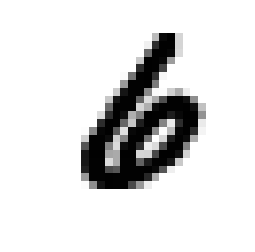

In [38]:
plt.subplot(1, 1, 1)
plt.axis('off')
plt.imshow((np.reshape(np.array(image), (28, 28)) * 255).astype(np.uint8), cmap=plt.cm.gray_r, interpolation='nearest')

In [39]:
predictions = client.deployments.score(scoring_url, payload)
print('Scoring result: ' + str(predictions['values']))

Scoring result: [6]


### 8.3 Delete the deployed model

Use the following method to delete the deployment when it is not needed

In [40]:
deployment_id = client.deployments.get_uid(deployment_details)

In [41]:
client.deployments.delete(deployment_id)

'SUCCESS'

<a id="summary"></a>
## 9. Summary

In this notebook we learnt how to create a custom python operation using Tensorflow's `tf.py_func` and used it on the LeNet model for MNIST.

We also learnt how to use `watson-machine-learning-client` to store a library created for using the same operation into WML Repository.

Finally, we stored our custom LeNet model with references to the created library into WML Repository which could be deployed and scored later using WML Service.

To explore the functionalities of Watson Studio further, check out our [Online Documentation](https://dataplatform.ibm.com/docs/content/analyze-data/wml-setup.html) for more samples, tutorials, documentation, how-tos, and blog posts.

### Citations

Y. LeCun, L. Bottou, Y. Bengio, and P. Haffner. "Gradient-based learning applied to document recognition." Proceedings of the IEEE, 86(11):2278-2324, November 1998.

### Authors

**Srikrishna S Bhat**, M. Tech, is a Software Engineer at IBM Watson Machine Learning Team